# Climatological product

> Setelah membaca chapter ini \| pembaca diharapkan dapat membuat produk klimatologis (peta spasial dan diagram windrose) berdasarkan wilayah pelayanan provinsi.

## Intro

Pada chapter sebelumnya, kita telah mencoba mengolah data multi dimensi menggunakan data sampel, mulai dari operasi dasar hingga visualisasi data pada peta spasial. Chapter ini akan menggabungkan beberapa chapter sebelumnya untuk membuat produk klimatologi spasial, area, dan titik. Terdapat tiga proses:
- load data: inacawo, inawaves, dan inaflows. Khusus untuk pelatihan ini, data sample tersedia selama tahun 2020-2025 untuk inawaves dan inaflows, serta 2025-sekarang untuk inacawo.
- preprocess data: agregrasi (perhitungan klimatologi).
- plot data: peta spasial, wind & wave rose.

Dalam hal ini, kita akan menggunakan template script yang telah disimpan dalam bentuk modul (`klimtool.py`) untuk mempermudah pemrosesan. 

Script `klimtool.py` berisi beberapa `class`, namun hanya `class` `klimtool` yang akan dipanggil di notebook ini. `class` `klimtool` memiliki method yang ditujukan sebagai data loader, preprocessor, hingga plotter. Untuk setiap langkah yang diselesaikan dengan memanggil modul tersebut, terdapat penjelasan singkat agar pembaca dapat memahami alur dari pemrosesan data.

## Load module & dataset

| Method | Deskripsi | Argumen mandatory |
| :- | :- | :- |
| `klimtool.open_inawaves` | Membuka dataset inawaves | - `tstart: datetime` \|<br> - `tend: datetime` \|<br> - `latlon: list[float]` | 
| `klimtool.open_inaflows` | Membuka dataset inaflows | - `tstart: datetime` \|<br> - `tend: datetime` \|<br> - `latlon: list[float]` | 
| `klimtool.open_inacawo` | Membuka dataset inacawo | - `tstart: datetime` \|<br> - `tend: datetime` \|<br> - `latlon: list[float]` | 

dimana
- `tstart` | `tend` -> masing-masing merupakan batas waktu awal dan akhir.
- `latlon` -> list berisi batas kiri dan kanan (longitude) serta bawah dan atas (latitude).

### Load module

In [1]:
from klimtool import klimtool # main module

import datetime
import geopandas as gpd
import rioxarray
import os

klimtool = klimtool()

### Definisikan batas waktu dan area

In [2]:
timestart = datetime.datetime(2020,1,1)
timeend   = datetime.datetime(2025,5,1)
lonw = 90
lone = 145
latb = -15
latt = 15
latlon = [lonw, lone, latb, latt]

### Load Inawaves

In [3]:
%%time
dsinawaves = klimtool.open_inawaves(tstart=timestart, tend=timeend, latlon=latlon)
dsinawaves

/home/tyo/marinemet-training/2_/klimtool.py:378: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dset = xr.open_zarr(self.__INAWAVE_PATH__)


CPU times: user 295 ms, sys: 80.9 ms, total: 376 ms
Wall time: 897 ms


<xarray.Dataset> Size: 238GB
Dimensions:  (time: 8768, lat: 481, lon: 881)
Coordinates:
  * lat      (lat) float64 4kB -15.0 -14.94 -14.88 -14.81 ... 14.88 14.94 15.0
  * lon      (lon) float64 7kB 90.0 90.06 90.12 90.19 ... 144.9 144.9 145.0
  * time     (time) datetime64[ns] 70kB 2022-01-01 ... 2024-12-31T21:00:00
Data variables: (12/16)
    dir      (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    hmax     (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    hs       (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    lm       (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    pdi00    (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    pdi01    (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    ...       ...
    ptp00    (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    ptp01    (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    ptp02    (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    t01      (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    uwnd     (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
    vwnd     (time, lat, lon) float32 15GB dask.array<chunksize=(8, 481, 881), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    description:  InaWaves Model - Merge Hindcast, Reanalysis, and Forecast
    email:        produksi.maritim@bmkg.go.id
    institution:  BMKG - Center For Marine Meteorology
    source:       WaveWatch3 forced by GFS Model

### Load Inaflows

In [4]:
%%time
dsinaflows = klimtool.open_inaflows(tstart=timestart, tend=timeend, latlon=latlon)
dsinaflows

CPU times: user 63.5 ms, sys: 143 ms, total: 207 ms
Wall time: 777 ms


<xarray.Dataset> Size: 84GB
Dimensions:  (time: 8768, lat: 751, lon: 638)
Coordinates:
  * lat      (lat) float64 6kB -15.0 -14.96 -14.92 -14.88 ... 14.92 14.96 15.0
  * lon      (lon) float64 5kB 94.0 94.08 94.16 94.24 ... 144.8 144.9 145.0
  * time     (time) datetime64[ns] 70kB 2022-01-01 ... 2024-12-31T21:00:00
Data variables:
    S        (time, lat, lon) float32 17GB dask.array<chunksize=(8, 751, 638), meta=np.ndarray>
    T        (time, lat, lon) float32 17GB dask.array<chunksize=(8, 751, 638), meta=np.ndarray>
    u        (time, lat, lon) float32 17GB dask.array<chunksize=(8, 751, 638), meta=np.ndarray>
    v        (time, lat, lon) float32 17GB dask.array<chunksize=(8, 751, 638), meta=np.ndarray>
    zeta     (time, lat, lon) float32 17GB dask.array<chunksize=(8, 751, 638), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

In [5]:
%%time
dsinacawo = klimtool.open_inacawo(tstart=timestart, tend=timeend, latlon=latlon)
dsinacawo

CPU times: user 4.14 s, sys: 124 ms, total: 4.26 s
Wall time: 4.28 s


<xarray.Dataset> Size: 185GB
Dimensions:  (time: 673, lat: 1200, lon: 2201)
Coordinates:
  * lat      (lat) float64 10kB -15.0 -14.97 -14.95 -14.92 ... 14.93 14.95 14.98
  * lon      (lon) float64 18kB 90.0 90.02 90.05 90.08 ... 144.9 145.0 145.0
  * time     (time) datetime64[ns] 5kB 2025-04-01 ... 2025-05-01
Data variables: (12/27)
    S        (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    T        (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    ch       (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    cycle    (time) datetime64[ns] 5kB dask.array<chunksize=(2,), meta=np.ndarray>
    dir      (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    gust     (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    ...       ...
    uw       (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    uwnd     (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    v        (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    vw       (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    vwnd     (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
    zeta     (time, lat, lon) float32 7GB dask.array<chunksize=(2, 1200, 2201), meta=np.ndarray>
Attributes:
    contact:      produksi.maritim@bmkg.go.id
    conventions:  CF-1.8
    description:  Indonesia Coupled Atmosphere Wave Ocean (InaCAWO)
    institution:  BMKG - Center For Marine Meteorology
    source:       InaCAWO - 3km High Resolution

### Load Inacawo

## Processing - Agregrasi data

Tahap processing pada pembuatan produk klimatologi dilakukan dengan tujuan untuk melakukan agregrasi statistik sesuai dengan kebutuhan analisis klimatologi. Setidaknya terdapat tiga hal yang mesti diperhatikan | yaitu waktu | lokasi | dan parameter statistik.

| No | Parameter | Deskripsi | Method `xarray` yang digunakan |
| :- | :- | :- | :- |
| 1. | Waktu | Merujuk pada batas dan frekuensi waktu yang akan diproses. Frekuensi waktu<br>- `1H`: per1jam (hanya untuk dataset inacawo)<br>- `3H`: per3jam<br>- `1D`: harian<br>- `MS`: bulanan<br>- `YS`: Tahunan<br> | - `.sel` & `.isel`: seleksi batas dimensi waktu<br>- `.groupby`: grouping dimensi waktu berdasarkan frekuensi tertentu<br> - `resample`: resampling dimensi waktu | 
| 2. | Lokasi | Merujuk pada batas spasial \| area wilayah provinsi \| atau lokasi titik | - `.sel` & `.isel`: seleksi batas dimensi waktu<br> - `clipping` kombinasi dengan `geopandas` & `rioxarray` untuk memotong area wilayah provinsi |
| 3. | Statistik | Merujuk pada parameter statistik untuk proses agregrasi data. Parameter yang umum digunakan: <br> - rata-rata<br> - maximum<br> - minimum<br> - standar deviasi<br> - percentile | - `.mean` \| `.max` \| `.min` \| `.std` \| `.sum` \| `.median` \| `.quantile`  |

## Klimatologi Spasial

| Method | Deskripsi | Argument mandatory | Opsi |
| :- | :- | :- | :- |
| `klimtool.plot_map` | Plotting untuk peta spasial | 1. `model:str`<br>2. `ds:Dataset`<br>3. `timefreq:str`<br>4. `var:str`<br>5. `area_type:str`<br>6. `area_name:str`<br>7. `map_title: str`<br>8. `out_dir:str` | 1. `inawave` \| `inaflow` \| `inacawo`<br>2. `xarray.Dataset`<br>3. `1H` \| `MS`<br>4. `swh` \| `ws` \| `psh` \| `wsh` \| `csd` \| `s` \| `st` \| `sl`<br>5. `wilpro` \| `False`<br>6. `indonesia`  \|  `aceh` \| `babel` \| `bali` \| `banten` \| `bengkulu` \| `diy` \| `dki_jabar` \| `gorontalo` \| `jambi` \| `jateng` \| `jatim` \| `kalbar` \| `kalsel` \| `kaltara` \| `kalteng` \| `kaltim` \| `kep_riau` \| `lampung` \| `maluku` \| `maluku_utara` \| `ntb` \| `ntt` \| `papua_barat` \| `papua_barat_daya` \| `papua_selatan` \| `papua_tengah` \| `riau` \| `sulbar` \| `sulsel` \| `sulteng` \| `sultra` \| `sulut` \| `sumbar` \| `sumut` \| `sumsel`<br>7. `False` \| Custom<br>8. Custom |

### Processing

Batas lokasi sudah didefine waktu proses load dataset, sehingga di tahap ini tidak perlu diulang. Kecuali jika pembaca menghendaki untuk area yang lebih spesifik, maka dataset bisa diseleksi untuk area yang diinterest. 

Oleh karena itu, pada tahap ini, kita bisa melakukan proses agregasi sesuai dengan parameter statistik yang dibutuhkan.

Pada case ini, kita akan mencoba melakukan agregasi dataset inawaves untuk menghitung nilai rata-rata bulanan.

#### inawaves

In [6]:
dsinawavesagregated = dsinawaves.groupby('time.month')
dsinawavesmean = dsinawavesagregated.mean()
dsinawavesmean

<xarray.Dataset> Size: 325MB
Dimensions:  (month: 12, lat: 481, lon: 881)
Coordinates:
  * lat      (lat) float64 4kB -15.0 -14.94 -14.88 -14.81 ... 14.88 14.94 15.0
  * lon      (lon) float64 7kB 90.0 90.06 90.12 90.19 ... 144.9 144.9 145.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables: (12/16)
    dir      (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    hmax     (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    hs       (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    lm       (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    pdi00    (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    pdi01    (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ...       ...
    ptp00    (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ptp01    (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ptp02    (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    t01      (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    uwnd     (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    vwnd     (month, lat, lon) float32 20MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    description:  InaWaves Model - Merge Hindcast, Reanalysis, and Forecast
    email:        produksi.maritim@bmkg.go.id
    institution:  BMKG - Center For Marine Meteorology
    source:       WaveWatch3 forced by GFS Model

Proses diatas menghasilkan grouped dataset berdasarkan bulanan. Tiap-tiap grup berisi dataset untuk bulan tersebut selama periode waktu tersimpan dalam dataset.

Selain `.groupby`, kita juga bisa menggunakan `.resample` dengan sedikit perubahan syntax.
```python
dsinawaves.resample(time='MS')
```

Untuk mendapatkan nilai rata-rata, method `.mean` bisa dijalankan, kita simpan dalam variabel `dsinawavesmean`.

Proses diatas menghasilkan dataset berisi rata-rata bulanan selama periode waktu tersimpan di dataset (3 tahun, 2022-2024). Selanjutnya, kita dapat melakukan plotting.

In [7]:
dsinaflowsmean = dsinaflows.groupby('time.month').mean()
dsinaflowsmean

<xarray.Dataset> Size: 115MB
Dimensions:  (month: 12, lat: 751, lon: 638)
Coordinates:
  * lat      (lat) float64 6kB -15.0 -14.96 -14.92 -14.88 ... 14.92 14.96 15.0
  * lon      (lon) float64 5kB 94.0 94.08 94.16 94.24 ... 144.8 144.9 145.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    S        (month, lat, lon) float32 23MB dask.array<chunksize=(1, 751, 638), meta=np.ndarray>
    T        (month, lat, lon) float32 23MB dask.array<chunksize=(1, 751, 638), meta=np.ndarray>
    u        (month, lat, lon) float32 23MB dask.array<chunksize=(1, 751, 638), meta=np.ndarray>
    v        (month, lat, lon) float32 23MB dask.array<chunksize=(1, 751, 638), meta=np.ndarray>
    zeta     (month, lat, lon) float32 23MB dask.array<chunksize=(1, 751, 638), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Plotting

In [8]:
model     = 'inawave'
ds        = dsinawavesmean.isel(month=0)
timefreq  = 'MS'
var       = 'swh'
area_type = 'wilpro'
area_name = 'indonesia' # ganti sesuai wilayah provinsi untuk menampilkan shp
map_title = 'Klimatologi SWH bulan January (2022-2024)'
file_out   = 'out/spasial/klimatologi_swh_january.png'

if not os.path.exists(os.path.dirname(file_out)):
    os.makedirs(os.path.dirname(file_out))

klimtool.plot_map(
    model=model,
    ds=ds,
    timefreq=timefreq,
    var=var,
    area_type=area_type,
    area_name=area_name,
    map_title=map_title,
    file_name=file_out
)

24
17.725174701023914


18
13.810792149686822
File tersimpan di out/spasial/klimatologi_swh_january.png


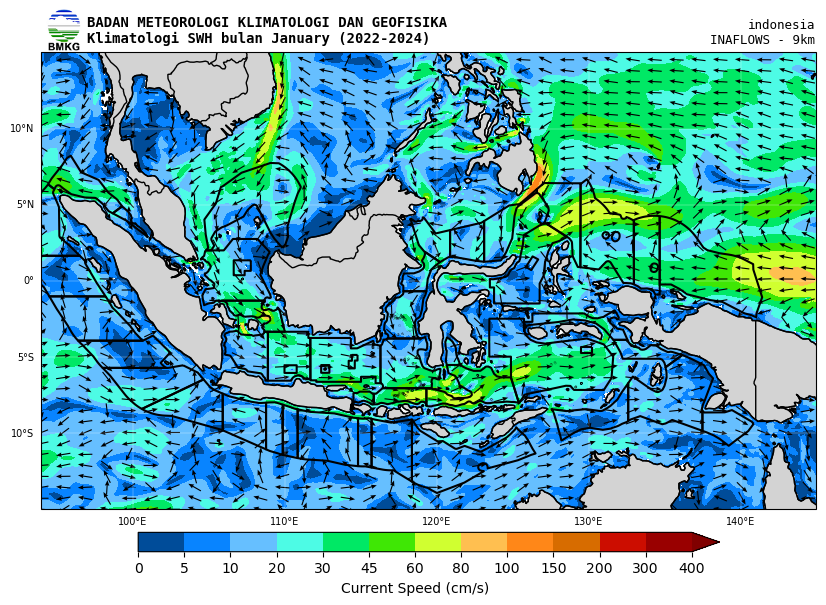

In [9]:
model     = 'inaflow'
ds        = dsinaflowsmean.isel(month=0)
timefreq  = 'MS'
var       = 'csd'
area_type = 'wilpro' # ganti sesuai wilayah pelayanan, atau biarkan kosong
area_name = 'indonesia' # ganti sesuai wilayah pelayanan, atau biarkan kosong
map_title = 'Klimatologi SWH bulan January (2022-2024)'
file_out   = 'out/spasial/klimatologi_swh_january.png'

if not os.path.exists(os.path.dirname(file_out)):
    os.makedirs(os.path.dirname(file_out))

klimtool.plot_map(
    model=model,
    ds=ds,
    timefreq=timefreq,
    var=var,
    area_type=area_type,
    area_name=area_name,
    map_title=map_title,
    file_name=file_out
)

## Klimatologi Area dan titik

| Method | Deskripsi | Argument mandatory |
| :- | :- | :- |
| `klimtool.plot_rose` | Memulai plotting untuk wind dan wave rose | `model:str` | `ds:xarray.Dataset` | `timefreq:str` | `var:str` | `area_type:str` | `area_name:str` |  `map_title: str` | `out_dir:str` |

### Processing - Area dan Titik

Output akhir pada proses ini adalah dalam bentuk titik dan time series.

| Lokasi | Deskripsi | Method |
| :- | :- | :- |
| Area | Area spasial yang ditentukan melalui batas latitude dan longitude atau mengikuti Wilayah Provinsi| - `.sel` dan `.isel`<br>- `rioxarray.clip`|
| Titik | Lokasi di satu titik | - `sel` dan `.isel`<br>- `interpolate` |

Dataset yang telah diseleksi untuk area tertentu dilakukan pemrosesan agregasi spasial untuk mendapatkan data time series. Pada kesempatan ini, kita hanya akan membahas agregasi rata-rata spasial `.mean`.

Dalam hal ini, kita akan memproses dataset menggunakan method `.resample` untuk mendapatkan rata-rata bulanan selama tiga tahun terakhir.

In [10]:
dsinawavesdaily = dsinawaves.resample(time='MS').mean()
dsinawavesdaily

<xarray.Dataset> Size: 976MB
Dimensions:  (time: 36, lat: 481, lon: 881)
Coordinates:
  * lat      (lat) float64 4kB -15.0 -14.94 -14.88 -14.81 ... 14.88 14.94 15.0
  * lon      (lon) float64 7kB 90.0 90.06 90.12 90.19 ... 144.9 144.9 145.0
  * time     (time) datetime64[ns] 288B 2022-01-01 2022-02-01 ... 2024-12-01
Data variables: (12/16)
    dir      (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    hmax     (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    hs       (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    lm       (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    pdi00    (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    pdi01    (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ...       ...
    ptp00    (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ptp01    (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    ptp02    (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    t01      (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    uwnd     (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
    vwnd     (time, lat, lon) float32 61MB dask.array<chunksize=(1, 481, 881), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    description:  InaWaves Model - Merge Hindcast, Reanalysis, and Forecast
    email:        produksi.maritim@bmkg.go.id
    institution:  BMKG - Center For Marine Meteorology
    source:       WaveWatch3 forced by GFS Model

#### Area

Pada case ini, kita akan mencoba untuk memproses salah satu wilayah Provinsi (Perairan Kep. Seribu Bagian Utara).

In [11]:
shp = gpd.read_file("/data/local/shpmetoswilpro/METOS_WILPRO_20231018.shp")
shp.columns

Index(['FID_METOS_', 'OBJECTID', 'DIS', 'Perairan', 'Met_Area', 'Label', 'ID',
       'sub_ID', 'ID_MAR', 'ID_Stat', 'wilpro', 'geometry'],
      dtype='object')

##### Check wilayah masing-masing UPT

In [12]:
shp.Perairan.unique()

array([None, 'Aceh', 'Sumatra Utara', 'Riau', 'Sumatra Barat', 'Bengkulu',
       'Jambi', 'Sumatra Selatan', 'Jawa Barat', 'Jawa Tengah',
       'Kep. Riau', 'Kalimantan Barat', 'Kep. Bangka Belitung',
       'DKI Jakarta', 'Kalimantan Selatan', 'Kalimantan Utara',
       'Kalimantan Timur', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Gorontalo', 'Sulawesi Tengah', 'Sulawesi Selatan', 'Maluku Utara',
       'Sulawesi Utara', 'Papua', 'Papua Tengah', 'Papua Selatan',
       'DI Yogyakarta', 'Maluku', 'Sulawesi Barat', 'Kalimantan Tengah',
       'Jawa Timur', 'Banten', 'Lampung', 'Papua Barat Daya',
       'Papua Barat', 'Sulawesi Tenggara', 'Bali'], dtype=object)

In [13]:
# Check Wilayah Provinsi masing-masing
shp[shp['Perairan'] == 'DKI Jakarta'] # <= ganti DKI Jakarta sesuai UPT masing-masing

,FID_METOS_,OBJECTID,DIS,Perairan,Met_Area,Label,ID,sub_ID,ID_MAR,ID_Stat,wilpro,geometry
56,2,1,1.0,DKI Jakarta,None,P,1,None,P.J.1,J,Perairan Kep. Seribu Bagian Utara,"POLYGON Z ((106.93456 -5.70765 0, 106.58471 -5..."
105,2,1,1.0,DKI Jakarta,None,P,3,None,P.J.3,J,Teluk Jakarta,"POLYGON Z ((106.97053 -6.09146 0, 106.9705 -6...."
262,2,1,1.0,DKI Jakarta,None,P,2,None,P.J.2,J,Perairan Kep. Seribu Bagian Selatan,"POLYGON Z ((106.57856 -5.70746 0, 106.57854 -5..."


##### Clip dataset

In [14]:
shp_sel = shp[shp['wilpro'] == 'Perairan Kep. Seribu Bagian Utara']
shp_sel

,FID_METOS_,OBJECTID,DIS,Perairan,Met_Area,Label,ID,sub_ID,ID_MAR,ID_Stat,wilpro,geometry
56,2,1,1.0,DKI Jakarta,None,P,1,None,P.J.1,J,Perairan Kep. Seribu Bagian Utara,"POLYGON Z ((106.93456 -5.70765 0, 106.58471 -5..."


<Axes: >

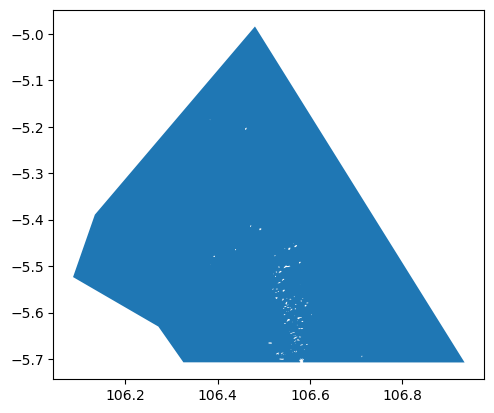

In [15]:
# QUICK PLOT
shp_sel.plot()

In [16]:
shp_sel = shp_sel.to_crs("EPSG:4326")
dset_clipped = dsinawavesdaily.rio.write_crs("EPSG:4326").rio.clip(shp_sel.geometry, shp_sel.crs, drop=True)
dset_clipped

<xarray.Dataset> Size: 330kB
Dimensions:      (lat: 11, lon: 13, time: 36)
Coordinates:
  * lat          (lat) float64 88B -5.688 -5.625 -5.562 ... -5.188 -5.125 -5.062
  * lon          (lon) float64 104B 106.1 106.2 106.2 ... 106.8 106.8 106.9
  * time         (time) datetime64[ns] 288B 2022-01-01 2022-02-01 ... 2024-12-01
    spatial_ref  int64 8B 0
Data variables: (12/16)
    dir          (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    hmax         (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    hs           (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    lm           (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    pdi00        (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    pdi01        (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    ...           ...
    ptp00        (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    ptp01        (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    ptp02        (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    t01          (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    uwnd         (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
    vwnd         (time, lat, lon) float32 21kB dask.array<chunksize=(1, 11, 13), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    description:  InaWaves Model - Merge Hindcast, Reanalysis, and Forecast
    email:        produksi.maritim@bmkg.go.id
    institution:  BMKG - Center For Marine Meteorology
    source:       WaveWatch3 forced by GFS Model

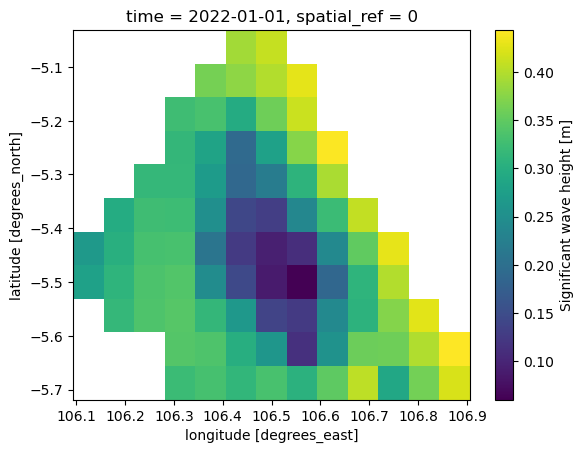

In [17]:
# QUICK PLOT
dset_clipped['hs'].isel(time=0).plot()

In [18]:
# AGREGASI SPASIAL
dset_clipped_mean = dset_clipped.mean(dim=['lon','lat'])
dset_clipped_mean

<xarray.Dataset> Size: 3kB
Dimensions:      (time: 36)
Coordinates:
  * time         (time) datetime64[ns] 288B 2022-01-01 2022-02-01 ... 2024-12-01
    spatial_ref  int64 8B 0
Data variables: (12/16)
    dir          (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    hmax         (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    hs           (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    lm           (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    pdi00        (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    pdi01        (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ...           ...
    ptp00        (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ptp01        (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ptp02        (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    t01          (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    uwnd         (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    vwnd         (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>

#### Titik

Pada case ini, kita akan mencoba untuk memproses lokasi lat lon berikut: -5.78 & 106.84 menggunakan metode nearest untuk mendapatkan grid terdekat dengan titik tersebut.

In [19]:
dset_loc_sel = dsinawavesdaily.sel(lat=-5.78, lon=106.84, method='nearest')
dset_loc_sel

<xarray.Dataset> Size: 3kB
Dimensions:  (time: 36)
Coordinates:
    lat      float64 8B -5.75
    lon      float64 8B 106.8
  * time     (time) datetime64[ns] 288B 2022-01-01 2022-02-01 ... 2024-12-01
Data variables: (12/16)
    dir      (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    hmax     (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    hs       (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    lm       (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    pdi00    (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    pdi01    (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ...       ...
    ptp00    (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ptp01    (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    ptp02    (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    t01      (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    uwnd     (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
    vwnd     (time) float32 144B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.8
    description:  InaWaves Model - Merge Hindcast, Reanalysis, and Forecast
    email:        produksi.maritim@bmkg.go.id
    institution:  BMKG - Center For Marine Meteorology
    source:       WaveWatch3 forced by GFS Model

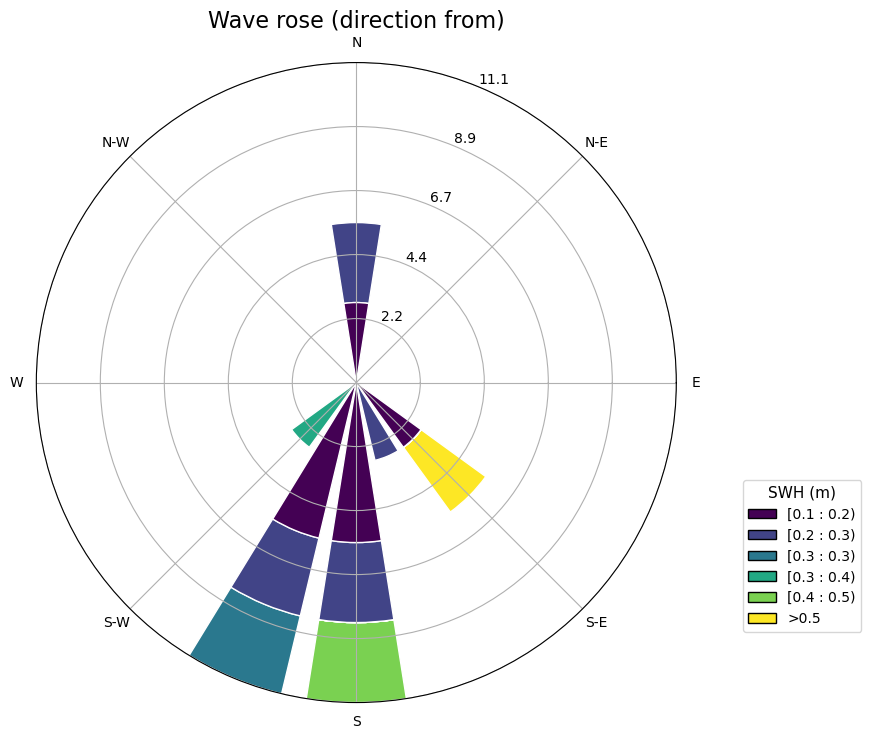

In [29]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
ax_ws = WindroseAxes.from_ax(fig=fig)
ax_ws.bar(
    dset_loc_sel['dir'].values,
    dset_loc_sel['hs'].values,
    normed=True,
    opening=0.8,
    edgecolor="white"
)

ax_ws.set_title('Wave rose (direction from)', fontsize=16)

ax_ws.legend(
    title='SWH (m)',
    loc='lower right',
    bbox_to_anchor=(1.3, 0.1),
    fontsize=10,
    title_fontsize=11,
    frameon=True
)
